In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

Modified timestamps for file u00001s00001_hw00002.svc:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32




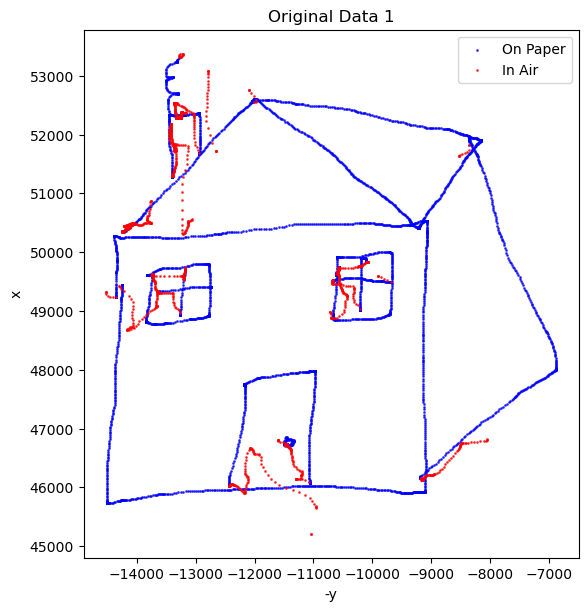

Number of processed files: 1
Average number of data points: 5553


In [2]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames  # Return the filenames

directory = 'Task2'  # Directory where the .svc files are stored
num_files_to_use = 1
data_frames, processed_data, scalers, avg_data_points, input_filenames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

In [21]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 30000].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 20000

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 70

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)

    # Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [22]:

# Define a valid directory path where you want to save the files
output_dir = './imputed/'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save each processed DataFrame to its corresponding output file
for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)
    
    # Define the output filename
    output_filename = input_filename.replace('.svc', '.svc')  # Modify filename
    output_path = os.path.join(output_dir, output_filename)
    
    # Save the DataFrame as a space-separated .svc file
    df.to_csv(output_path, sep=' ', index=False, header=False)

    print(f"File saved to: {output_path}")


File saved to: ./imputed/u00001s00001_hw00002.svc


Modified timestamps for file u00001s00001_hw00002.svc:
0     0
1     8
2    15
3    23
4    30
Name: timestamp, dtype: int32




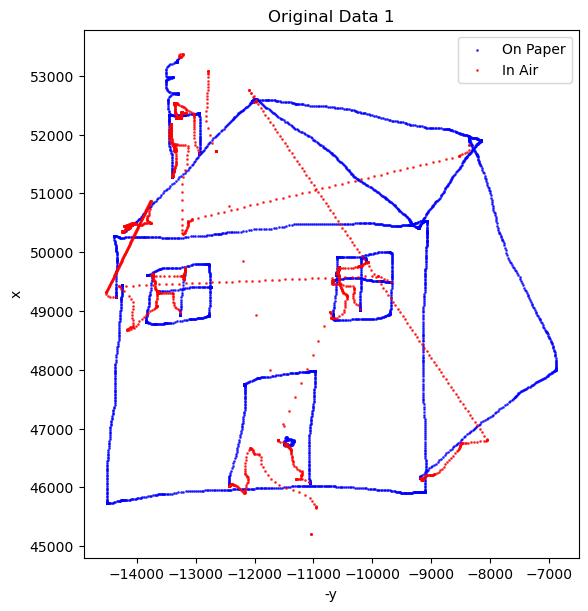

Number of processed files: 1
Average number of data points: 5970


In [23]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points

directory = './imputed'  # Directory where the .svc files are stored

data_frames, processed_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [24]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, **kwargs):  # Added **kwargs to handle extra arguments
        super(VAE, self).__init__(**kwargs)  # Pass kwargs to the parent class
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        # Handle any unexpected keys like 'trainable' by removing them
        config.pop('trainable', None)
        config.pop('dtype', None)  # Also remove 'dtype' if included
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        # Add the VAE-specific arguments
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 128
beta = 0.0001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [25]:
# Cell 4 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        
        # Retain original columns for pressure, azimuth, and altitude
        original_data = data_frames[i % num_input_files]  # Use original unprocessed data
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        # Determine the number of points for this augmented dataset
        # num_points = int(avg_data_points * (1 + np.random.uniform(-length_variability, length_variability)))
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        # Encode and reparameterize
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()
        
        # # Adjust number of points
        # if num_points > augmented_data.shape[0]:
        #     extra_indices = np.random.choice(augmented_data.shape[0], num_points - augmented_data.shape[0])
        #     augmented_data = np.vstack((augmented_data, augmented_data[extra_indices]))
        # elif num_points < augmented_data.shape[0]:
        #     keep_indices = np.random.choice(augmented_data.shape[0], num_points, replace=False)
        #     augmented_data = augmented_data[keep_indices]

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        # Append the pressure, azimuth, and altitude columns from the original data
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/30: 100%|██████████| 12/12 [00:07<00:00,  1.67batch/s, Generator Loss=0.000637, Reconstruction Loss=0.000298, KL Loss=3.39]


Epoch 1: Generator Loss = 0.000620, Reconstruction Loss = 0.000286, KL Divergence Loss = 3.342556
NRMSE = 0.308664


Epoch 2/30: 100%|██████████| 12/12 [00:00<00:00, 42.47batch/s, Generator Loss=0.000607, Reconstruction Loss=0.00028, KL Loss=3.28] 


Epoch 2: Generator Loss = 0.000633, Reconstruction Loss = 0.000300, KL Divergence Loss = 3.329655
NRMSE = 0.308460


Epoch 3/30: 100%|██████████| 12/12 [00:00<00:00, 36.36batch/s, Generator Loss=0.00066, Reconstruction Loss=0.000333, KL Loss=3.28] 


Epoch 3: Generator Loss = 0.000602, Reconstruction Loss = 0.000269, KL Divergence Loss = 3.324721
NRMSE = 0.309002


Epoch 4/30: 100%|██████████| 12/12 [00:00<00:00, 28.16batch/s, Generator Loss=0.000602, Reconstruction Loss=0.00027, KL Loss=3.32] 


Epoch 4: Generator Loss = 0.000598, Reconstruction Loss = 0.000266, KL Divergence Loss = 3.319388
NRMSE = 0.308523


Epoch 5/30: 100%|██████████| 12/12 [00:00<00:00, 26.49batch/s, Generator Loss=0.000649, Reconstruction Loss=0.000311, KL Loss=3.39]


Epoch 5: Generator Loss = 0.000614, Reconstruction Loss = 0.000282, KL Divergence Loss = 3.316289
NRMSE = 0.308061


Epoch 6/30: 100%|██████████| 12/12 [00:00<00:00, 42.97batch/s, Generator Loss=0.000594, Reconstruction Loss=0.000268, KL Loss=3.26]


Epoch 6: Generator Loss = 0.000601, Reconstruction Loss = 0.000270, KL Divergence Loss = 3.306150
NRMSE = 0.309293


Epoch 7/30: 100%|██████████| 12/12 [00:00<00:00, 40.46batch/s, Generator Loss=0.000692, Reconstruction Loss=0.00035, KL Loss=3.42] 


Epoch 7: Generator Loss = 0.000626, Reconstruction Loss = 0.000296, KL Divergence Loss = 3.300163
NRMSE = 0.307733


Epoch 8/30: 100%|██████████| 12/12 [00:00<00:00, 44.36batch/s, Generator Loss=0.00055, Reconstruction Loss=0.000223, KL Loss=3.27] 


Epoch 8: Generator Loss = 0.000638, Reconstruction Loss = 0.000309, KL Divergence Loss = 3.283941
NRMSE = 0.309416


Epoch 9/30: 100%|██████████| 12/12 [00:00<00:00, 23.85batch/s, Generator Loss=0.000622, Reconstruction Loss=0.000293, KL Loss=3.29]


Epoch 9: Generator Loss = 0.000626, Reconstruction Loss = 0.000299, KL Divergence Loss = 3.270205
NRMSE = 0.308129


Epoch 10/30: 100%|██████████| 12/12 [00:00<00:00, 44.84batch/s, Generator Loss=0.000575, Reconstruction Loss=0.00025, KL Loss=3.25] 


Epoch 10: Generator Loss = 0.000594, Reconstruction Loss = 0.000268, KL Divergence Loss = 3.259152
NRMSE = 0.308541


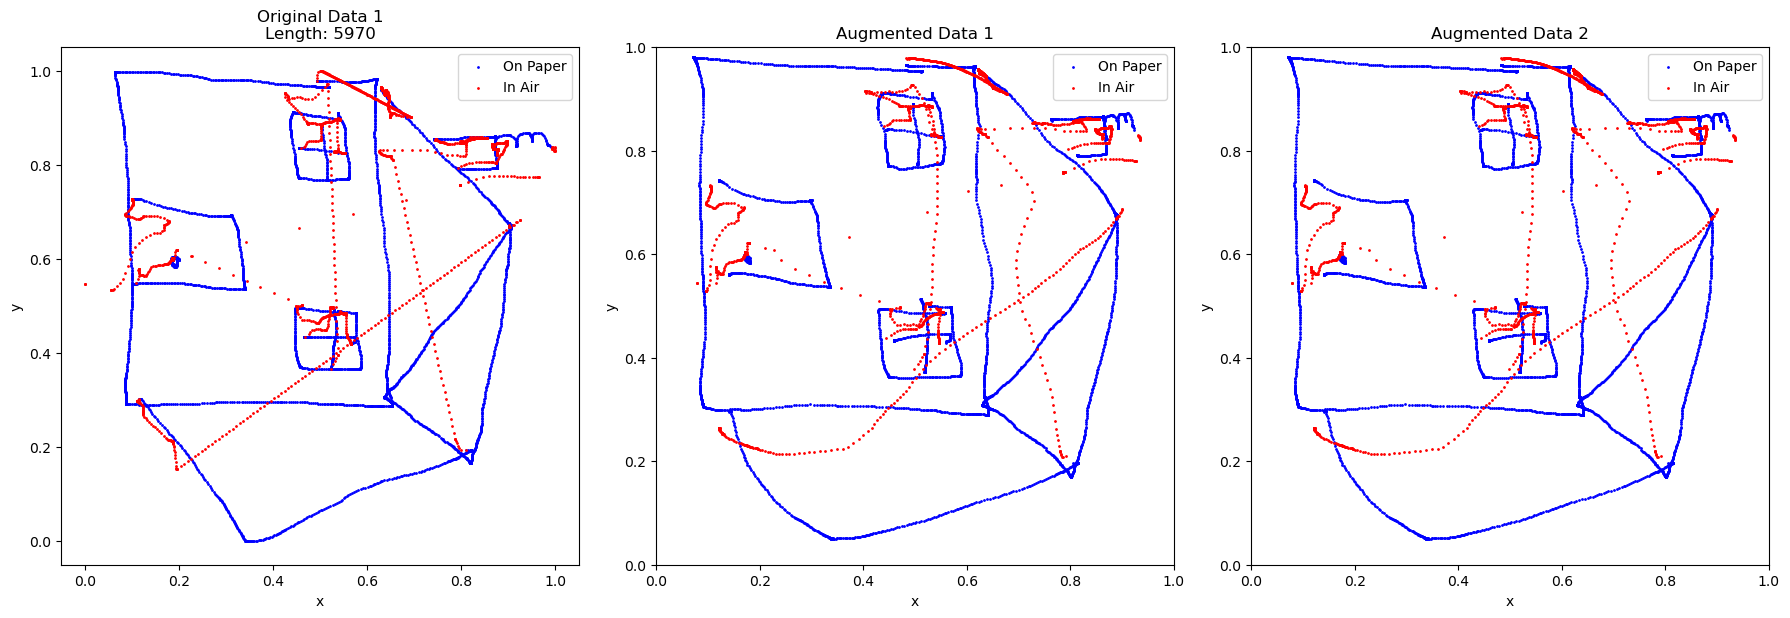

Epoch 11/30: 100%|██████████| 12/12 [00:00<00:00, 43.11batch/s, Generator Loss=0.00055, Reconstruction Loss=0.000231, KL Loss=3.2]  


Epoch 11: Generator Loss = 0.000573, Reconstruction Loss = 0.000248, KL Divergence Loss = 3.253532
NRMSE = 0.308176


Epoch 12/30: 100%|██████████| 12/12 [00:00<00:00, 43.60batch/s, Generator Loss=0.000625, Reconstruction Loss=0.000292, KL Loss=3.32]


Epoch 12: Generator Loss = 0.000579, Reconstruction Loss = 0.000254, KL Divergence Loss = 3.253198
NRMSE = 0.309045


Epoch 13/30: 100%|██████████| 12/12 [00:00<00:00, 28.22batch/s, Generator Loss=0.000569, Reconstruction Loss=0.00024, KL Loss=3.28] 


Epoch 13: Generator Loss = 0.000578, Reconstruction Loss = 0.000253, KL Divergence Loss = 3.250652
NRMSE = 0.308084


Epoch 14/30: 100%|██████████| 12/12 [00:00<00:00, 38.64batch/s, Generator Loss=0.000535, Reconstruction Loss=0.000216, KL Loss=3.19]


Epoch 14: Generator Loss = 0.000560, Reconstruction Loss = 0.000235, KL Divergence Loss = 3.244079
NRMSE = 0.308323


Epoch 15/30: 100%|██████████| 12/12 [00:00<00:00, 46.23batch/s, Generator Loss=0.000595, Reconstruction Loss=0.000274, KL Loss=3.21]


Epoch 15: Generator Loss = 0.000583, Reconstruction Loss = 0.000259, KL Divergence Loss = 3.240433
NRMSE = 0.308221


Epoch 16/30: 100%|██████████| 12/12 [00:00<00:00, 42.48batch/s, Generator Loss=0.000609, Reconstruction Loss=0.000287, KL Loss=3.22]


Epoch 16: Generator Loss = 0.000588, Reconstruction Loss = 0.000264, KL Divergence Loss = 3.234487
NRMSE = 0.307902


Epoch 17/30: 100%|██████████| 12/12 [00:00<00:00, 31.85batch/s, Generator Loss=0.00055, Reconstruction Loss=0.000237, KL Loss=3.13] 


Epoch 17: Generator Loss = 0.000560, Reconstruction Loss = 0.000237, KL Divergence Loss = 3.226813
NRMSE = 0.308513


Epoch 18/30: 100%|██████████| 12/12 [00:00<00:00, 45.75batch/s, Generator Loss=0.000553, Reconstruction Loss=0.000234, KL Loss=3.19]


Epoch 18: Generator Loss = 0.000567, Reconstruction Loss = 0.000245, KL Divergence Loss = 3.220177
NRMSE = 0.308182


Epoch 19/30: 100%|██████████| 12/12 [00:00<00:00, 40.06batch/s, Generator Loss=0.000514, Reconstruction Loss=0.000197, KL Loss=3.18]


Epoch 19: Generator Loss = 0.000557, Reconstruction Loss = 0.000236, KL Divergence Loss = 3.215611
NRMSE = 0.308165


Epoch 20/30: 100%|██████████| 12/12 [00:00<00:00, 42.97batch/s, Generator Loss=0.00059, Reconstruction Loss=0.000267, KL Loss=3.24] 


Epoch 20: Generator Loss = 0.000555, Reconstruction Loss = 0.000234, KL Divergence Loss = 3.211326
NRMSE = 0.308533


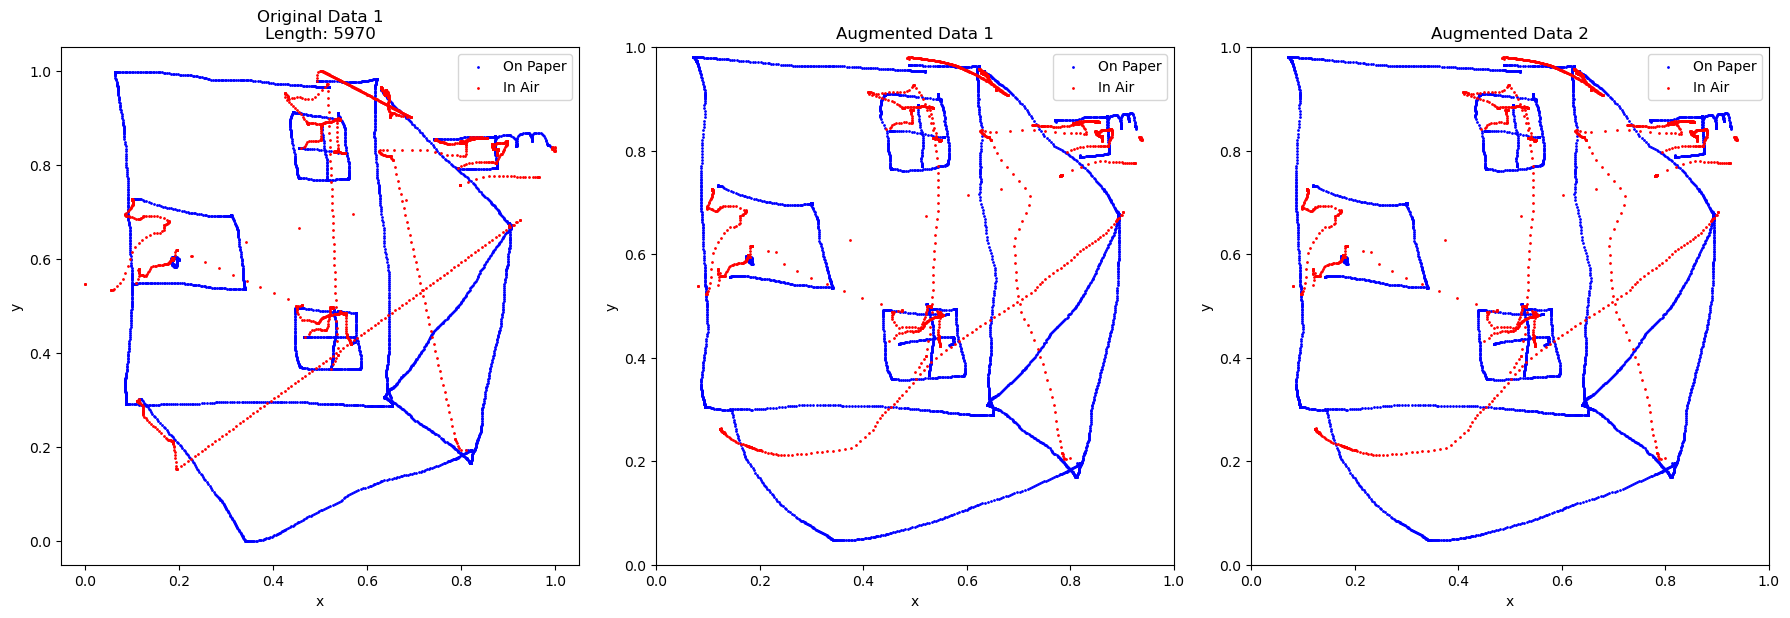

Epoch 21/30: 100%|██████████| 12/12 [00:00<00:00, 38.04batch/s, Generator Loss=0.000516, Reconstruction Loss=0.000195, KL Loss=3.21]


Epoch 21: Generator Loss = 0.000559, Reconstruction Loss = 0.000239, KL Divergence Loss = 3.203792
NRMSE = 0.308477


Epoch 22/30: 100%|██████████| 12/12 [00:00<00:00, 44.56batch/s, Generator Loss=0.000583, Reconstruction Loss=0.000263, KL Loss=3.19]


Epoch 22: Generator Loss = 0.000554, Reconstruction Loss = 0.000235, KL Divergence Loss = 3.199133
NRMSE = 0.308168


Epoch 23/30: 100%|██████████| 12/12 [00:00<00:00, 43.41batch/s, Generator Loss=0.000561, Reconstruction Loss=0.000244, KL Loss=3.18]


Epoch 23: Generator Loss = 0.000560, Reconstruction Loss = 0.000241, KL Divergence Loss = 3.187518
NRMSE = 0.308395


Epoch 24/30: 100%|██████████| 12/12 [00:00<00:00, 24.51batch/s, Generator Loss=0.000567, Reconstruction Loss=0.000248, KL Loss=3.19]


Epoch 24: Generator Loss = 0.000549, Reconstruction Loss = 0.000231, KL Divergence Loss = 3.179320
NRMSE = 0.308271


Epoch 25/30: 100%|██████████| 12/12 [00:00<00:00, 43.24batch/s, Generator Loss=0.000515, Reconstruction Loss=0.000196, KL Loss=3.2] 


Epoch 25: Generator Loss = 0.000545, Reconstruction Loss = 0.000228, KL Divergence Loss = 3.171808
NRMSE = 0.310487


Epoch 26/30: 100%|██████████| 12/12 [00:00<00:00, 42.01batch/s, Generator Loss=0.000569, Reconstruction Loss=0.000253, KL Loss=3.16]


Epoch 26: Generator Loss = 0.000550, Reconstruction Loss = 0.000234, KL Divergence Loss = 3.165440
NRMSE = 0.308771


Epoch 27/30: 100%|██████████| 12/12 [00:00<00:00, 44.41batch/s, Generator Loss=0.000537, Reconstruction Loss=0.000219, KL Loss=3.18]


Epoch 27: Generator Loss = 0.000553, Reconstruction Loss = 0.000237, KL Divergence Loss = 3.157649
NRMSE = 0.308027


Epoch 28/30: 100%|██████████| 12/12 [00:00<00:00, 40.53batch/s, Generator Loss=0.000529, Reconstruction Loss=0.000223, KL Loss=3.06]


Epoch 28: Generator Loss = 0.000547, Reconstruction Loss = 0.000232, KL Divergence Loss = 3.146288
NRMSE = 0.309539


Epoch 29/30: 100%|██████████| 12/12 [00:00<00:00, 19.35batch/s, Generator Loss=0.000553, Reconstruction Loss=0.000241, KL Loss=3.12]


Epoch 29: Generator Loss = 0.000542, Reconstruction Loss = 0.000227, KL Divergence Loss = 3.142021
NRMSE = 0.308462


Epoch 30/30: 100%|██████████| 12/12 [00:00<00:00, 40.93batch/s, Generator Loss=0.000543, Reconstruction Loss=0.000226, KL Loss=3.17]


Epoch 30: Generator Loss = 0.000543, Reconstruction Loss = 0.000229, KL Divergence Loss = 3.139863
NRMSE = 0.308822


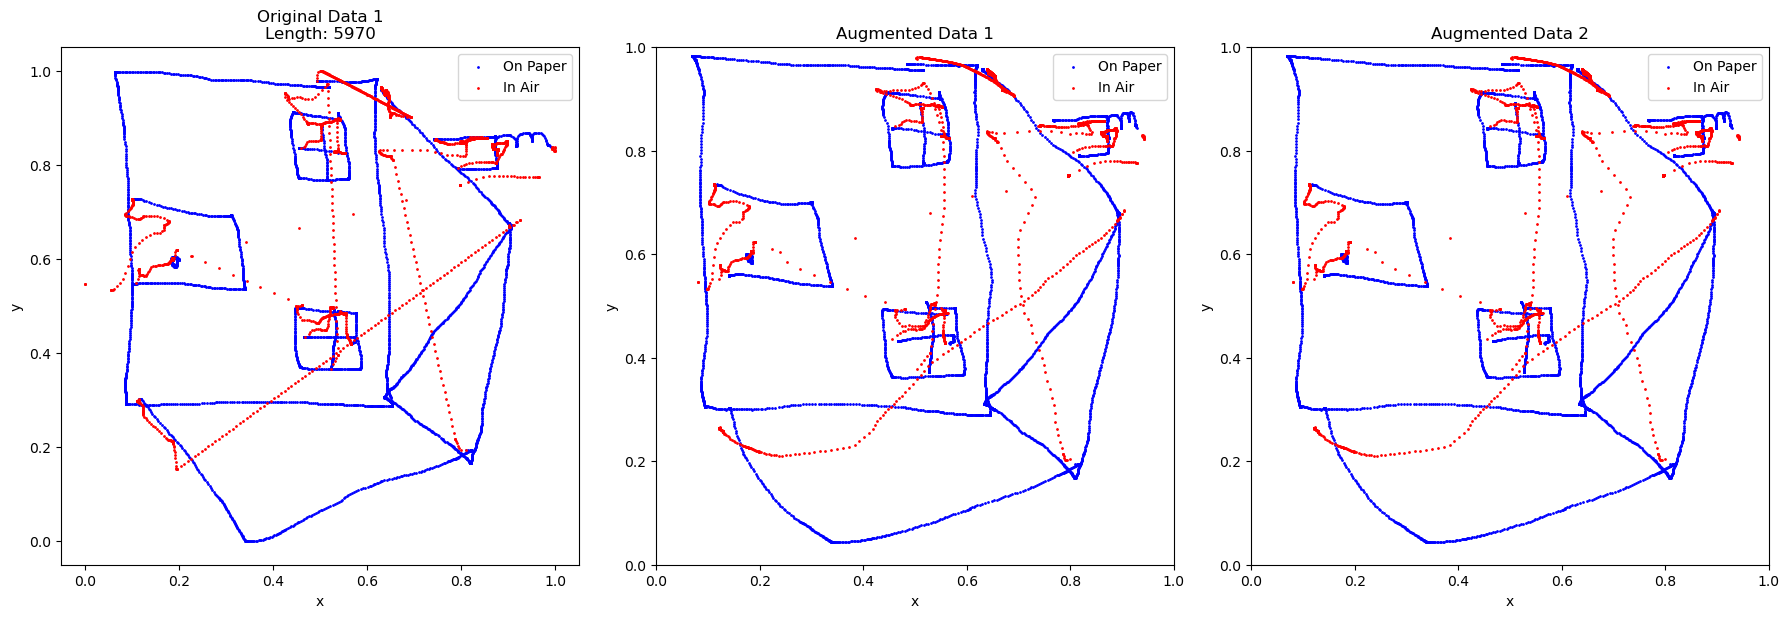

Final NRMSE: 0.308822
Training completed.
VAE model saved.


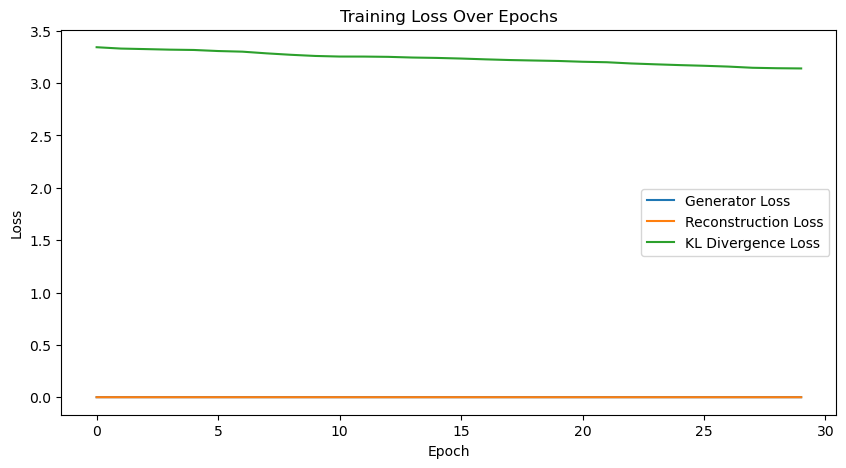

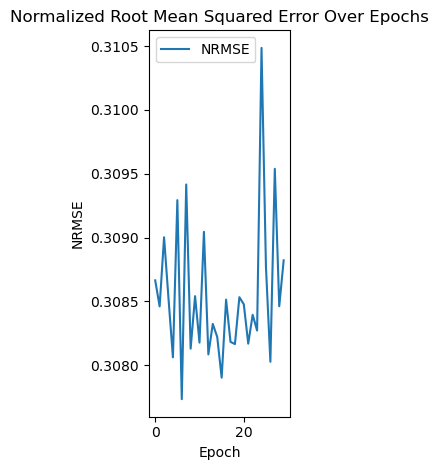

In [31]:
#Cell 5
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss - 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 99
lstm_interval = 1
epochs = 30
visual_per_num_epoch = 10
num_augmented_files = 2

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)
        # length_variability = 0.05
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))
        
        for i, original_data in enumerate(processed_data):
            original_on_paper = original_data[original_data[:, 3] == 1]
            original_in_air = original_data[original_data[:, 3] == 0]
            axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}\nLength: {len(original_data)}')
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('y')
            axs[i].set_aspect('equal')
            axs[i].legend()

        # Set consistent axis limits for square aspect ratio
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}')
            axs[i+len(processed_data)].set_xlabel('x')
            axs[i+len(processed_data)].set_ylabel('y')
            axs[i+len(processed_data)].set_aspect('equal')
            axs[i+len(processed_data)].set_xlim(x_min, x_max)
            axs[i+len(processed_data)].set_ylim(y_min, y_max)
            axs[i+len(processed_data)].legend()

        plt.tight_layout()
        plt.show()

# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

vae.save('saved_vae_model.h5')
print("VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.


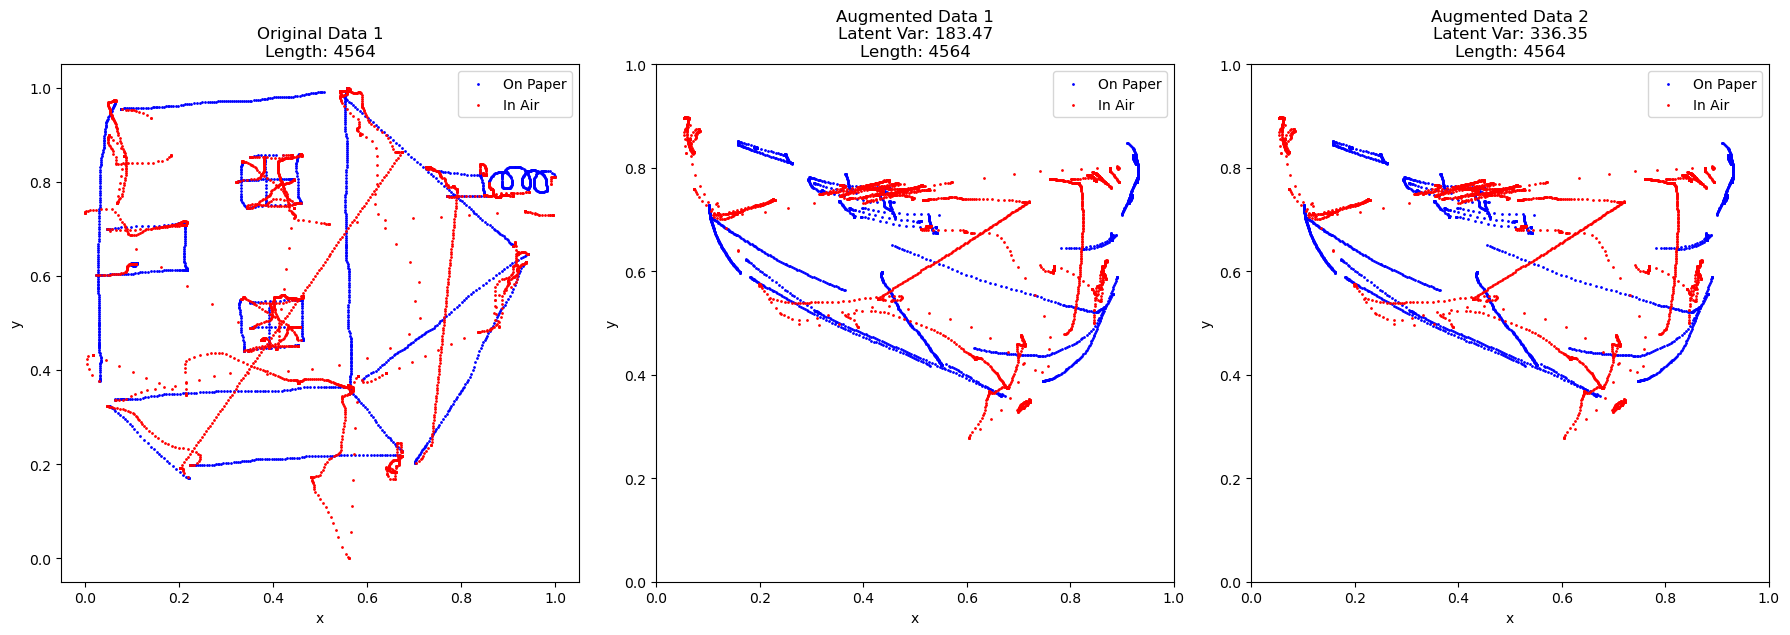

In [21]:
# Cell 6
# Load the pretrained VAE model
with custom_object_scope({'VAE': VAE}):
    vae_pretrained = load_model('saved_vae_model.h5')
print("Pretrained VAE model loaded.")
base_latent_variability = 100.0
latent_variability_range = (0.1, 5.0)
# length_variability = 0.05
num_augmented_files = 2
# Generate augmented data using the pretrained model
augmented_datasets = generate_augmented_data(vae_pretrained, num_augmented_files, avg_data_points, processed_data, 
                                             base_latent_variability, latent_variability_range)

# Calculate actual latent variabilities and lengths used
latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
augmented_lengths = [len(data) for data in augmented_datasets]

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))

for i, original_data in enumerate(processed_data):
    original_on_paper = original_data[original_data[:, 3] == 1]
    original_in_air = original_data[original_data[:, 3] == 0]
    axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i].set_title(f'Original Data {i+1}\nLength: {len(original_data)}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_aspect('equal')
    axs[i].legend()

# Set consistent axis limits for square aspect ratio
x_min = min(data[:, 0].min() for data in processed_data)
x_max = max(data[:, 0].max() for data in processed_data)
y_min = min(data[:, 1].min() for data in processed_data)
y_max = max(data[:, 1].max() for data in processed_data)

for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
    augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
    axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}\nLatent Var: {latent_var:.2f}\nLength: {length}')
    axs[i+len(processed_data)].set_xlabel('x')
    axs[i+len(processed_data)].set_ylabel('y')
    axs[i+len(processed_data)].set_aspect('equal')
    axs[i+len(processed_data)].set_xlim(x_min, x_max)
    axs[i+len(processed_data)].set_ylim(y_min, y_max)
    axs[i+len(processed_data)].legend()

plt.tight_layout()
plt.show()

In [28]:
def download_augmented_data_as_integers(augmented_datasets, scaler, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, original_df, original_filename) in enumerate(zip(augmented_datasets, original_data_frames, original_filenames)):
        # Ensure the arrays have matching sizes by trimming the larger one
        min_rows = min(len(augmented_data), len(original_df))
        
        # Trim augmented_data if necessary
        augmented_data_trimmed = augmented_data[:min_rows, :]
        
        # Trim original_df if necessary
        original_df_trimmed = original_df.iloc[:min_rows]

        # Reconstruct the original columns and round to nearest whole number
        augmented_data_original_scale = np.column_stack((
            np.rint(scaler.inverse_transform(augmented_data_trimmed[:, :3])).astype(int),  # Round and convert to integers: x, y, timestamp
            augmented_data_trimmed[:, 3].astype(int),  # Pen status (binary, ensure it's integer 0 or 1)
            np.rint(original_df_trimmed[['pressure', 'azimuth', 'altitude']].values).astype(int)  # Round pressure, azimuth, altitude to integers
        ))

        # Construct the new filename by modifying the original filename
        base_name, ext = os.path.splitext(original_filename)
        new_filename = os.path.join(directory, f'{base_name}_augmented{ext}')
        
        # Save each augmented dataset to a .svc file
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']).to_csv(new_filename, index=False, sep=' ', header=False)
        
        # Print the full file path to indicate where it's saved
        print(f"Saved {os.path.abspath(new_filename)}")

# Call the updated function with original filenames
# Make sure to pass the original filenames list when calling the function
download_augmented_data_as_integers(augmented_datasets, scalers[0], data_frames, original_filenames)

NameError: name 'original_filenames' is not defined

In [11]:
#Cell 8 Function to visualize the latent space with a color gradient
def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])

NameError: name 'TSNE' is not defined